In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx, degree, negative_sampling
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
net = pd.read_csv('BEELINE-data/inputs/Curated/HSC/HSC-2000-1/refNetwork.csv')
net.head()

,Gene1,Gene2,Type
0,Gata1,Eklf,+
1,Fli1,Eklf,-
2,Cebpa,Pu1,+
3,Pu1,Pu1,+
4,Gata1,Pu1,-


In [4]:
all_genes = set()
all_genes.update(['Pu1', 'EgrNab', 'cJun', 'Gfi1', 'Cebpa', 'Gata1', 'Gata2', 'Fog1', 'Fli1', 'Eklf', 'Scl'])

## Visualization of Gene Regulatory Networks in the HSC dataset

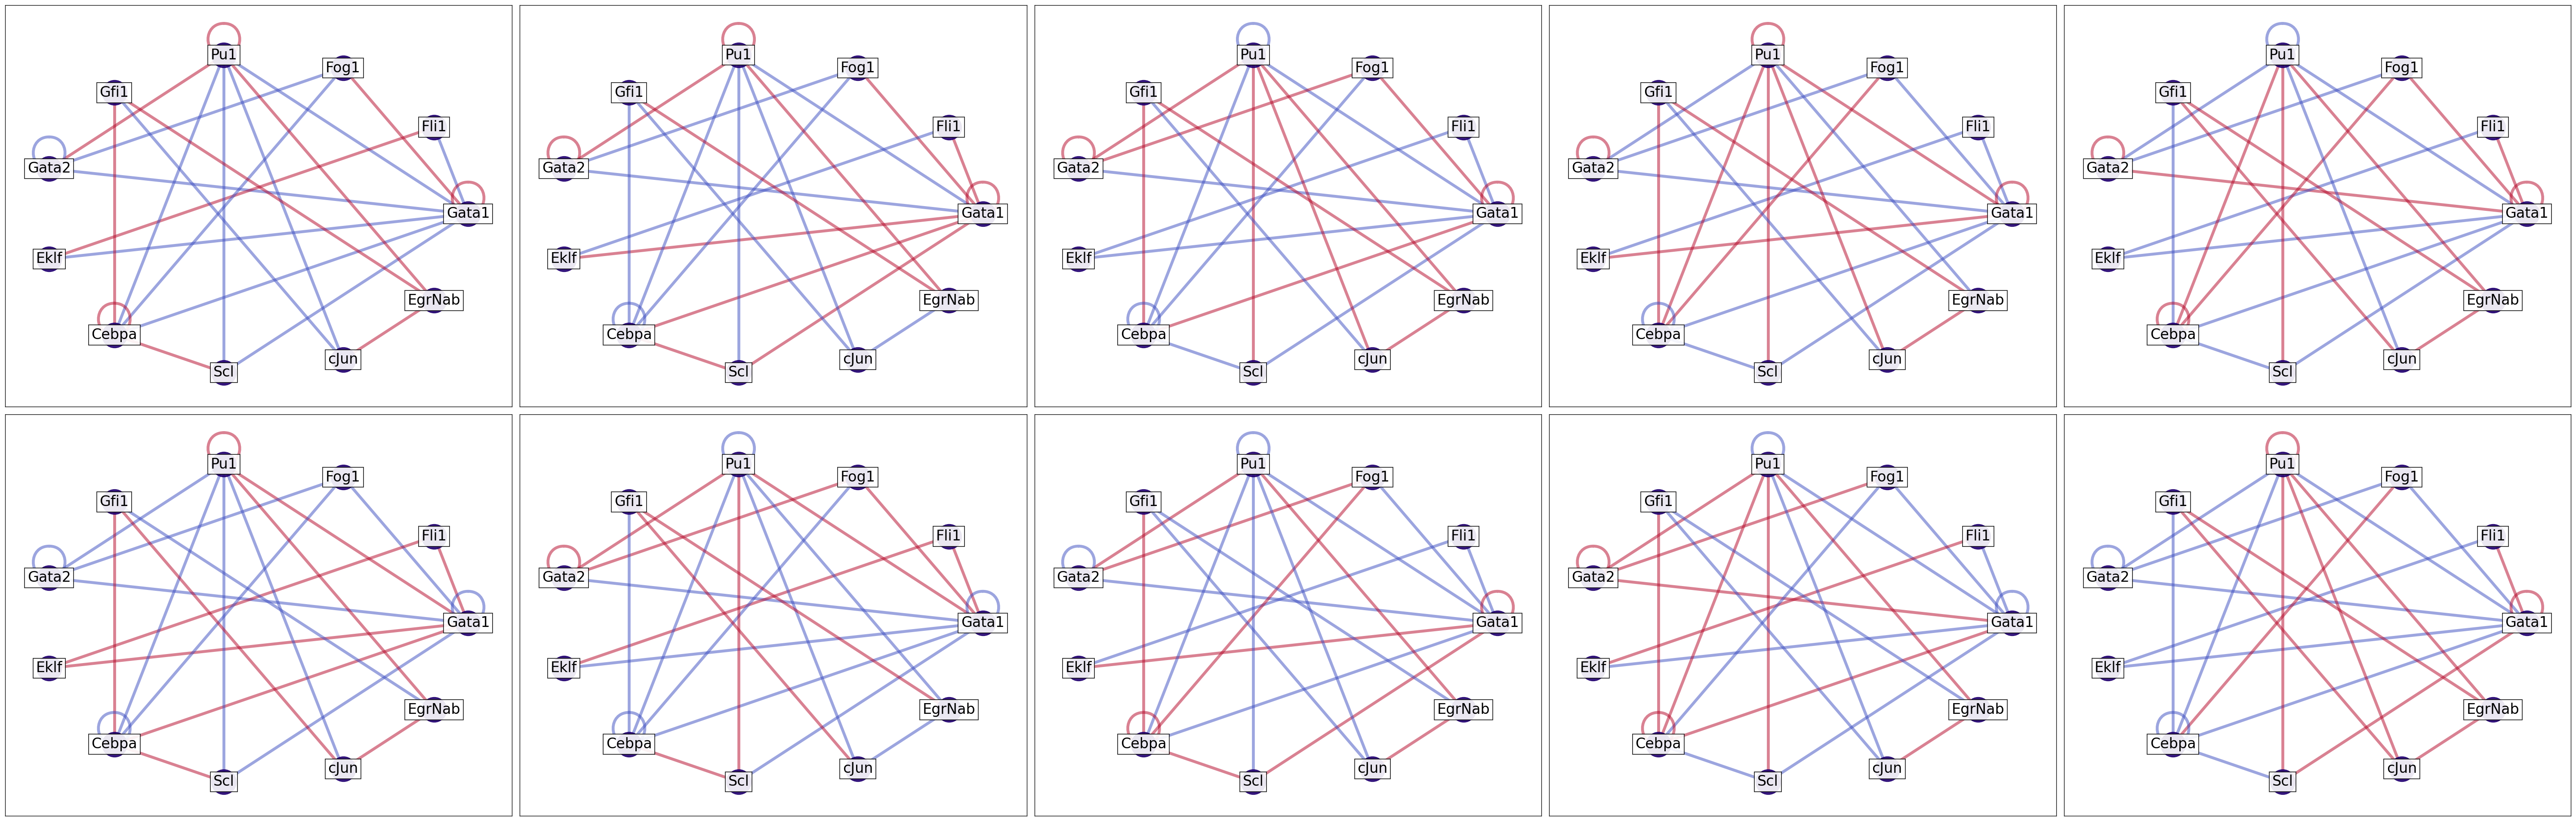

In [18]:
n = 10
cols = 5
rows = 2

# Set up the figure size, adjust as necessary based on your display or preferences
plt.figure(figsize=(10*cols, 8*rows), dpi=120)
#plt.title('Gene Regulatory Networks for HSC (10 Samples from 2000 Sim., Dropouts=50%)', fontsize=20)
plt.axis('off') 

for index in range(1, 11):
    network = pd.read_csv(f'BEELINE-data/inputs/Curated/HSC/HSC-2000-{index}-50/refNetwork.csv')
    
    G = nx.Graph()
    G.add_nodes_from(all_genes)
    colors = [(0.2298057, 0.298717966, 0.753683153, 0.75) if network.iloc[i, 2] == '+' else (0.705673158, 0.01555616, 0.150232812, 0.75) for i in range(len(network))]
    for i in range(len(network)):
        G.add_edge(network.iloc[i, 0], network.iloc[i, 1])

    # Create subplot for this network
    ax = plt.subplot(rows, cols, index)
    pos = nx.circular_layout(G)

    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#210070", alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=colors, width=4, edge_cmap=plt.cm.coolwarm, edge_vmin=-10, edge_vmax=10)
    nx.draw_networkx_labels(G, pos, font_size=20, bbox={"ec": "k", "fc": "white", "alpha": 0.9})

# Show the complete figure with all subplots
plt.tight_layout()
plt.savefig('BEELINE-data/inputs/Curated/metrics/GRN.png')
plt.show()


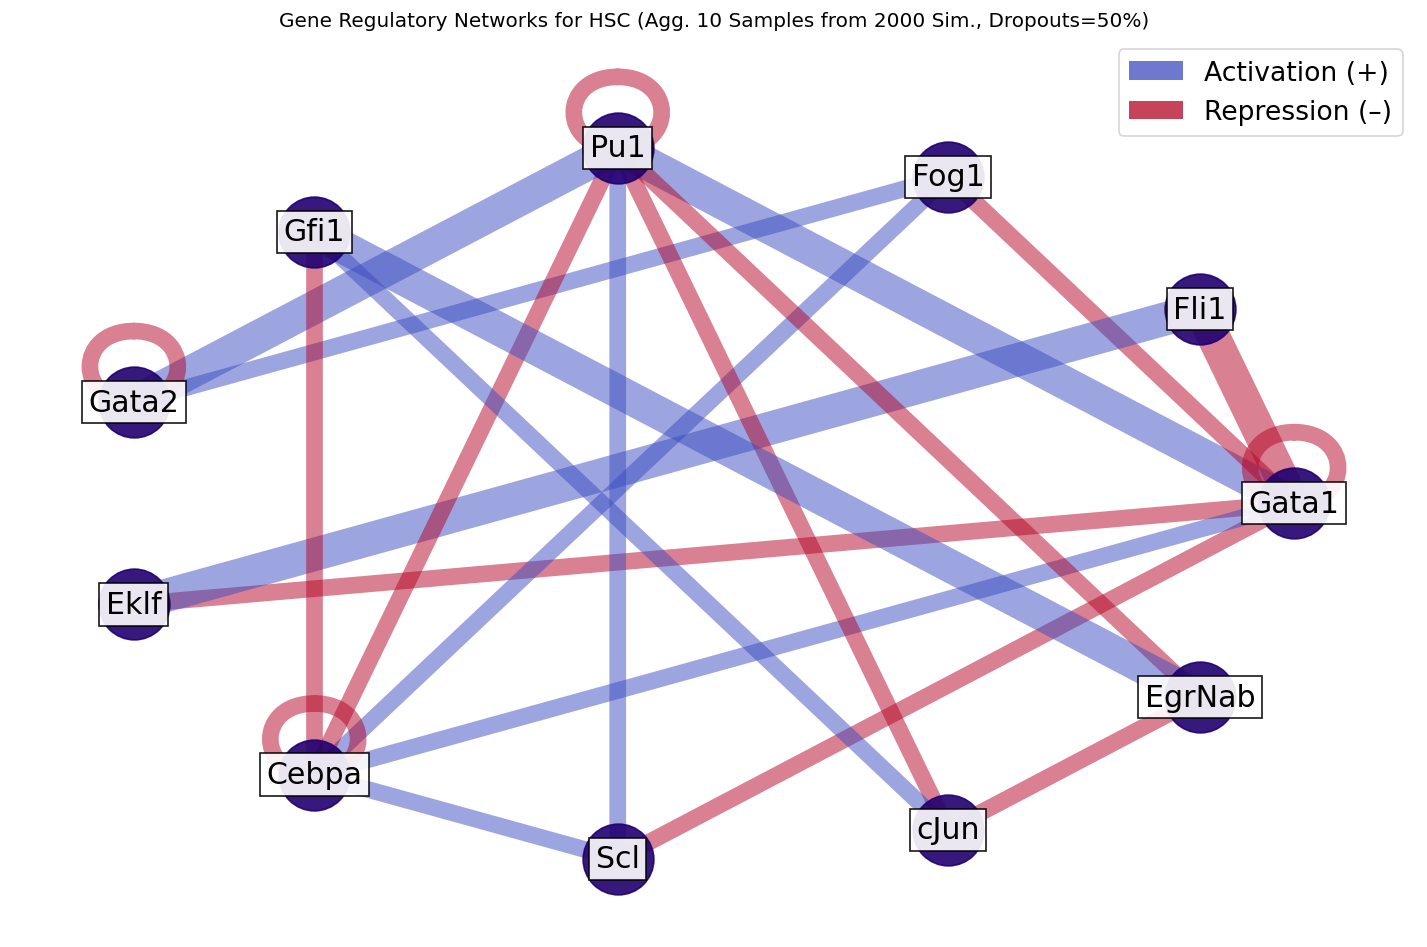

In [16]:
'''
Aggregation: 
Since we have 10 networks for each dropout rate, one approach could be to 
aggregate these networks into three composite networks, one for each dropout 
rate. This can be done by taking the union of all edges present in the ten 
networks for each dropout rate, possibly weighting the edges by their 
frequency of occurrence across the ten samples. This results in three 
networks representing the average connectivity for each dropout rate.
'''
G = nx.Graph()
G.add_nodes_from(all_genes)

for index in range(1, 11):
    network = pd.read_csv(f'BEELINE-data/inputs/Curated/HSC/HSC-2000-{index}-50/refNetwork.csv')
    
    for i in range(len(network)):

        edge_weight = (1 if network.iloc[i, 2] == '+' else -1)

        if not G.has_edge(network.iloc[i, 0], network.iloc[i, 1]):
            G.add_edge(network.iloc[i, 0], network.iloc[i, 1], weight=edge_weight)
        else:
            G[network.iloc[i, 0]][network.iloc[i, 1]]['weight'] += edge_weight

# Create a list of gradient colors based on the edge weights
colors = [ G[u][v]['weight'] for u, v in G.edges()]

plt.figure(figsize=(12, 8), dpi=120)
plt.title('Gene Regulatory Networks for HSC (Agg. 10 Samples from 2000 Sim., Dropouts=50%)')
plt.axis('off') 

pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=1800, node_color="#210070", alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=colors, width=[abs(G[u][v]['weight']) for u, v in G.edges()], edge_cmap=plt.cm.coolwarm, edge_vmin=-5, edge_vmax=5)
nx.draw_networkx_labels(G, pos, font_size=18, bbox={"ec": "k", "fc": "white", "alpha": 0.9})

# Show the complete figure with all subplots
plt.tight_layout()
plt.legend(handles=[
    Patch(facecolor=(0.2298057, 0.298717966, 0.753683153, 0.75),label='Activation (+)'), 
    Patch(facecolor=(0.705673158, 0.01555616, 0.150232812, 0.75),label='Repression (–)')],
    fontsize=16, loc='upper right'
    )
plt.savefig('BEELINE-data/inputs/Curated/metrics/GRN-Agg.png')
plt.show()

## Methodology

### Network Metrics:

In [32]:
G_agg = nx.Graph()
G_agg.add_nodes_from(all_genes)
graphs = []

for index in range(1, 11):
    network = pd.read_csv(f'BEELINE-data/inputs/Curated/HSC/HSC-2000-{index}-50/refNetwork.csv')
    
    G = nx.Graph()
    G.add_nodes_from(all_genes)
    
    for i in range(len(network)):
        G.add_edge(network.iloc[i, 0], network.iloc[i, 1], weight=(1 if network.iloc[i, 2] == '+' else -1))

        edge_weight = (1 if network.iloc[i, 2] == '+' else -1)

        if not G_agg.has_edge(network.iloc[i, 0], network.iloc[i, 1]):
            G_agg.add_edge(network.iloc[i, 0], network.iloc[i, 1], weight=edge_weight)
        else:
            G_agg[network.iloc[i, 0]][network.iloc[i, 1]]['weight'] += edge_weight
    
    graphs.append(G)

graphs.append(G_agg)

df_g = pd.DataFrame(columns=['Graph', 'Nodes', 'Edges', 'Max Degree', 'Min Degree', 'Avg Degree', 'Median Degree', 'Connected Components', 'Average Distance', 'Diameter', 'Transitivity', 'Average Clustering Coefficient', 'Clustering Coefficients', 'Degree Distribution', 'Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'Eigenvector Centrality', 'Hubs', 'Authorities'])

for i, G in enumerate(graphs):
    degrees = dict(G.degree()).values()

    df_g.loc[i] = [
        f'Sample {i+1}', 
        G.number_of_nodes(),
        G.number_of_edges(),
        max(degrees),
        min(degrees),
        np.mean(list(degrees)),
        np.median(list(degrees)),
        nx.number_connected_components(G),
        nx.average_shortest_path_length(G) if nx.is_connected(G) else None,
        nx.diameter(G) if nx.is_connected(G) else None,
        nx.transitivity(G),
        nx.average_clustering(G),
        nx.clustering(G),
        nx.degree_histogram(G),
        nx.degree_centrality(G),
        nx.closeness_centrality(G),
        nx.betweenness_centrality(G),
        nx.eigenvector_centrality(G),
        nx.hits(G)[0],
        nx.hits(G)[1]
    ]
    
    # plt.figure(figsize=(12, 8), dpi=120)
    # #plt.title(f'HSC GRN Sample {i+1}')
    # plt.axis('off')
    # plt.margins(0,0.01)

    # pos = nx.circular_layout(G)
    # nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#210070", alpha=0.9)
    # nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=colors, width=5, edge_cmap=plt.cm.coolwarm, edge_vmin=-10, edge_vmax=10)
    # nx.draw_networkx_labels(G, pos, font_size=20, bbox={"ec": "k", "fc": "white", "alpha": 0.9})

    # plt.tight_layout()
    # plt.savefig(f'BEELINE-data/inputs/Curated/metrics/Network Sample {i+1}.png',bbox_inches='tight')
    # #plt.show()

df_g.iloc[10, 0] = 'Aggregated'

df_g.to_csv('BEELINE-data/inputs/Curated/metrics/GRN-Stats.csv', index=False)
df_g

,Graph,Nodes,Edges,Max Degree,Min Degree,Avg Degree,Median Degree,Connected Components,Average Distance,Diameter,Transitivity,Average Clustering Coefficient,Clustering Coefficients,Degree Distribution,Degree Centrality,Closeness Centrality,Betweenness Centrality,Eigenvector Centrality,Hubs,Authorities
0,Sample 1,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.658595567874244, 'Fli1': 4.404047...","{'Gata1': 23.658595567873977, 'Fli1': 4.404047..."
1,Sample 2,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 2.6934709040043803, 'Fli1': 0.485749...","{'Gata1': 2.693470904004379, 'Fli1': 0.4857499..."
2,Sample 3,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.658595567874272, 'Fli1': 4.404047...","{'Gata1': 23.658595567874404, 'Fli1': 4.404047..."
3,Sample 4,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.658595567874062, 'Fli1': 4.404047...","{'Gata1': 23.65859556787429, 'Fli1': 4.4040479..."
4,Sample 5,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.65859556787409, 'Fli1': 4.4040479...","{'Gata1': 23.65859556787449, 'Fli1': 4.4040479..."
5,Sample 6,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.658595567874638, 'Fli1': 4.404047...","{'Gata1': 23.65859556787437, 'Fli1': 4.4040479..."
6,Sample 7,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.658595567874343, 'Fli1': 4.404047...","{'Gata1': 23.658595567874624, 'Fli1': 4.404047..."
7,Sample 8,11,24,9,2,4.363636,3.0,1,1.8,3,0.454545,0.642424,"{'Gata1': 0.3333333333333333, 'Fli1': 1.0, 'Fo...","[0, 0, 2, 5, 0, 1, 0, 1, 1, 1]","{'Gata1': 0.9, 'Fli1': 0.2, 'Fog1': 0.30000000...","{'Gata1': 0.7692307692307693, 'Fli1': 0.476190...","{'Gata1': 0.40814814814814815, 'Fli1': 0.0, 'F...","{'Gata1': 0.5073808258951236, 'Fli1': 0.129052...","{'Gata1': 23.658595567874144, 'Fli1': 4.404047...","{'Gata1': 23.658595567874038, 'Fli1': 4.404047..."
8,Sample 9,11,24,9,2,4.363636,3.0,1,1.8,3

In [234]:
# sort according to all_genes list
clust_coeff = nx.clustering(G_agg)
clust_coeff = {k: clust_coeff[k] for k in all_genes}

{'Fog1': 0.6666666666666666,
 'Scl': 1.0,
 'EgrNab': 0.6666666666666666,
 'Pu1': 0.3333333333333333,
 'cJun': 0.6666666666666666,
 'Fli1': 1.0,
 'Gata1': 0.3333333333333333,
 'Gata2': 0.6666666666666666,
 'Gfi1': 0.3333333333333333,
 'Eklf': 1.0,
 'Cebpa': 0.4}

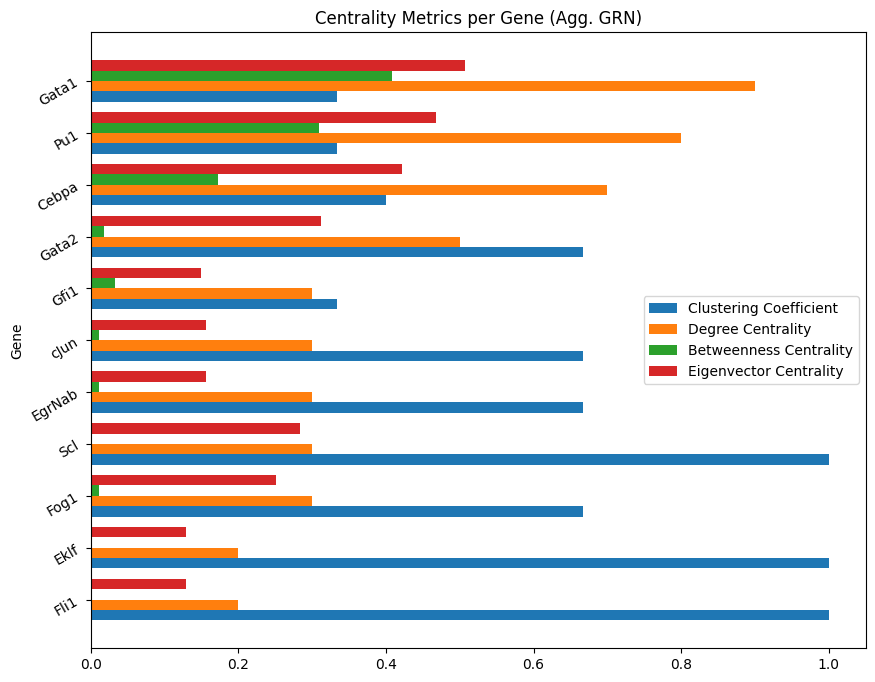

In [286]:
df = pd.read_csv('BEELINE-data/inputs/Curated/metrics/GRN-Stats.csv')

for index, row in df.iterrows():
    # print(f'{row[0]}')
    if index == 10:
        break

    # create a folder for each graph and save figures 
    network = pd.read_csv(f'BEELINE-data/inputs/Curated/HSC/HSC-2000-{index+1}-50/refNetwork.csv')
    G = nx.Graph()
    G.add_nodes_from(all_genes)
    colors = [(0.2298057, 0.298717966, 0.753683153, 0.75) if network.iloc[i, 2] == '+' else (0.705673158, 0.01555616, 0.150232812, 0.75) for i in range(len(network))]


    for i in range(len(network)):
        G.add_edge(network.iloc[i, 0], network.iloc[i, 1])

    
    # plt.figure(figsize=(12, 8), dpi=120)
    # #plt.title(f'HSC GRN Sample {i+1}')
    # plt.axis('off')
    # plt.margins(0,0.01)

    # pos = nx.circular_layout(G)
    # nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#210070", alpha=0.9)
    # nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color=colors, width=5, edge_cmap=plt.cm.coolwarm, edge_vmin=-10, edge_vmax=10)
    # nx.draw_networkx_labels(G, pos, font_size=20, bbox={"ec": "k", "fc": "white", "alpha": 0.9})

    # plt.tight_layout()
    # plt.savefig(f'BEELINE-data/inputs/Curated/metrics/Network Sample {i+1}.png',bbox_inches='tight')
    # #plt.show()
        

# Visualizing the clustering coefficient of each node 

X = all_genes
X_axis = np.arange(len(X)) 

clust_coeff = nx.clustering(G_agg)
deg_centrality = nx.degree_centrality(G_agg)
close_centrality = nx.closeness_centrality(G_agg)
bet_centrality = nx.betweenness_centrality(G_agg)
eigen_centrality = nx.eigenvector_centrality(G_agg)

# sort according to clust_coeff values 
X = sorted(X, key=lambda x: deg_centrality[x])

clust_coeff = {k: clust_coeff[k] for k in X}
deg_centrality = {k: deg_centrality[k] for k in X}
close_centrality = {k: close_centrality[k] for k in X}
bet_centrality = {k: bet_centrality[k] for k in X}
eigen_centrality = {k: eigen_centrality[k] for k in X}



plt.figure(figsize=(10, 8))
plt.set_cmap('gist_rainbow')

plt.barh(X_axis-0.4, list(clust_coeff.values()), height=0.2, align='edge')
plt.barh(X_axis-0.2, list(deg_centrality.values()), height=0.2, align='edge')
#plt.barh(X_axis, list(close_centrality.values()), height=0.2, align='edge')
plt.barh(X_axis+0.0, list(bet_centrality.values()), height=0.2, align='edge')
plt.barh(X_axis+0.2, list(eigen_centrality.values()), height=0.2, align='edge')

plt.yticks(rotation=30)
plt.yticks(X_axis, X)
plt.legend(['Clustering Coefficient', 'Degree Centrality', 'Betweenness Centrality', 'Eigenvector Centrality'])
plt.title('Centrality Metrics per Gene (Agg. GRN)')
plt.ylabel('Gene')
plt.savefig('BEELINE-data/inputs/Curated/metrics/GRN-Agg-Metrics.png')
plt.show()

### Identifying Key Regulators:

Use GNNs to identify key regulatory genes within the networks. 
By analyzing the importance of nodes within the graph (using techniques 
like attention mechanisms within GNNs), we can pinpoint genes that play 
central roles in the regulatory network and potentially in cell state 
determination or response to environmental cues.

In [255]:
N = 11
index_to_gene = {0: 'Fli1', 1: 'Gfi1', 2: 'Cebpa', 3: 'cJun', 4: 'Gata2', 5: 'EgrNab', 6: 'Pu1', 7: 'Eklf', 8: 'Fog1', 9: 'Scl', 10: 'Gata1'}
gene_to_index = {v: k for k, v in index_to_gene.items()}

# Load all networks and create a dataset
datasets = []

for index in range(1, 11):
    file_path = f'BEELINE-data/inputs/Curated/HSC/HSC-2000-{index}-50/refNetwork.csv'
    network = pd.read_csv(file_path)
    G = nx.Graph()
    G.add_nodes_from(all_genes)
    for i in range(len(network)):
        G.add_edge(network.iloc[i, 0], network.iloc[i, 1], weight=(1 if network.iloc[i, 2] == '+' else -1))

    edge_index = torch.tensor([[gene_to_index[edge[0]], gene_to_index[edge[1]]] for edge in G.edges], dtype=torch.long).t().contiguous()
    x = torch.eye(G.number_of_nodes())  # Node features as one-hot vectors
    data = Data(x=x.float(), edge_index=edge_index.long())
    datasets.append(data)

print(datasets)

# Batch and load the data
batch_size = 4
loader = DataLoader(datasets[1:], batch_size=batch_size, shuffle=True)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GATConv(in_channels=N, out_channels=8, heads=8, dropout=0.6)
        self.conv2 = GATConv(in_channels=8*8, out_channels=N, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.dropout(x, p=0.6, train=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Aggregate node features to graph features
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training the model
model.train()
for epoch in range(50):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, torch.zeros(batch_size, 1).to(device))
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss.item()}')


[Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24]), Data(x=[11, 11], edge_index=[2, 24])]


/Users/hakan/Desktop/INF538/venv/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead

/var/folders/63/4pgswjr50bn64058t7d156v80000gn/T/ipykernel_95360/2243351345.py:53: UserWarning:

Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 0, Loss: 0.021365057677030563
Epoch 0, Loss: 0.015402269549667835
Epoch 0, Loss: 0.01540316641330719
Epoch 1, Loss: 0.01933216117322445
Epoch 1, Loss: 0.01760324090719223
Epoch 1, Loss: 0.045927729457616806
Epoch 2, Loss: 0.008659658953547478
Epoch 2, Loss: 0.008626846596598625
Epoch 2, Loss: 0.012577485293149948
Epoch 3, Loss: 0.015395233407616615
Epoch 3, Loss: 0.010596979409456253
Epoch 3, Loss: 0.021122552454471588
Epoch 4, Loss: 0.020924709737300873
Epoch 4, Loss: 0.00962216779589653
Epoch 4, Loss: 0.014667081646621227
Epoch 5, Loss: 0.007998785935342312
Epoch 5, Loss: 0.005951991770416498
Epoch 5, Loss: 0.0007771208765916526
Epoch 6, Loss: 0.006200769450515509
Epoch 6, Loss: 0.003720005741342902
Epoch 6, Loss: 0.0026277415454387665
Epoch 7, Loss: 0.0038985370192676783
Epoch 7, Loss: 0.0034658098593354225
Epoch 7, Loss: 0.0032546110451221466
Epoch 8, Loss: 0.0024721890222281218
Epoch 8, Loss: 0.004576030652970076
Epoch 8, Loss: 0.008711458183825016
Epoch 9, Loss: 0.003661508

/var/folders/63/4pgswjr50bn64058t7d156v80000gn/T/ipykernel_95360/2243351345.py:53: UserWarning:

Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 33, Loss: 4.989239096175879e-05
Epoch 33, Loss: 9.83412901405245e-05
Epoch 33, Loss: 3.862520316033624e-05
Epoch 34, Loss: 2.3842661903472617e-05
Epoch 34, Loss: 2.9674685720237903e-05
Epoch 34, Loss: 2.9882272428949364e-05
Epoch 35, Loss: 3.0297453122329898e-05
Epoch 35, Loss: 6.86580387991853e-05
Epoch 35, Loss: 1.3254350051283836e-05
Epoch 36, Loss: 3.287400249973871e-05
Epoch 36, Loss: 2.2659351088805124e-05
Epoch 36, Loss: 2.4378125090152025e-05
Epoch 37, Loss: 1.874589543149341e-05
Epoch 37, Loss: 1.792291186575312e-05
Epoch 37, Loss: 2.6026396881206892e-05
Epoch 38, Loss: 2.1407558961072937e-05
Epoch 38, Loss: 1.914234417199623e-05
Epoch 38, Loss: 3.2748857847764157e-06
Epoch 39, Loss: 7.129227014956996e-05
Epoch 39, Loss: 6.92113462719135e-05
Epoch 39, Loss: 6.654033768427325e-06
Epoch 40, Loss: 5.483625136548653e-05
Epoch 40, Loss: 1.0699223821575288e-05
Epoch 40, Loss: 0.00025377669953741133
Epoch 41, Loss: 4.5594792027259246e-05
Epoch 41, Loss: 2.8450280296965502e-05
E

#### Analyzing node importance:

After training, we can interpret the model's attention weights to understand node importance
For GAT, attention weights can be extracted from the learned parameters.


In [256]:
# Fetch a single data sample
single_data = datasets[0].to(device)  # Example, using the first dataset

model.eval()
_, edge_index, _ = single_data.x, single_data.edge_index, single_data.batch
# Forward pass through model to get transformed node features
with torch.no_grad():
    node_importance = model(single_data).squeeze()

# node_importance now holds the significance scores for each node in the graph
# Higher values indicate more significant nodes in terms of their contribution to the network output

# Sort nodes by their importance scores
sorted_nodes = sorted(index_to_gene.items(), key=lambda x: node_importance[x[0]], reverse=True)

# Print out the top most important genes
print("Top N most important genes based on GNN analysis:")
for idx, (gene_idx, gene_name) in enumerate(sorted_nodes, start=1):
    print(f"{idx}: {gene_name} (Score: {node_importance[gene_idx].item()})")


Top N most important genes based on GNN analysis:
1: Gata2 (Score: 0.0035994260106235743)
2: Pu1 (Score: 0.0025698819663375616)
3: cJun (Score: 0.0008935125661082566)
4: EgrNab (Score: 0.0006330992910079658)
5: Gfi1 (Score: 0.0001901929354062304)
6: Eklf (Score: -0.0001897612091852352)
7: Scl (Score: -0.0004370731476228684)
8: Fli1 (Score: -0.0006421792786568403)
9: Gata1 (Score: -0.0014679246814921498)
10: Cebpa (Score: -0.0016235430957749486)
11: Fog1 (Score: -0.002121686702594161)


In [266]:
node_importance[gene_idx].item()

-0.002121686702594161

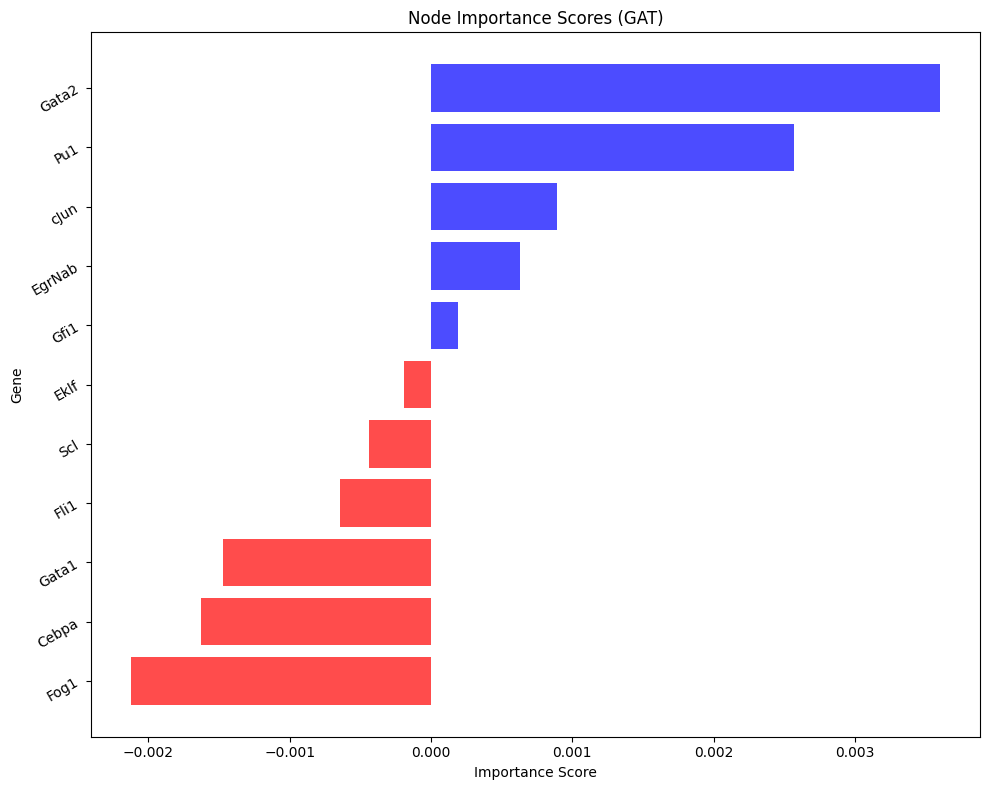

In [271]:
sorted_nodes = sorted(index_to_gene.items(), key=lambda x: node_importance[x[0]], reverse=False)

cmap = plt.get_cmap('gist_rainbow')
colors = [(0,0,1,0.7) if node_importance[gene_idx].item() > 0 else (1, 0, 0, 0.7) for gene_idx, _ in sorted_nodes]

plt.figure(figsize=(10, 8))
plt.title('Node Importance Scores (GAT)')
plt.ylabel('Gene')
plt.xlabel('Importance Score')
plt.yticks(rotation=30)
plt.barh([gene_name for _, gene_name in sorted_nodes], [node_importance[gene_idx].item() for gene_idx, _ in sorted_nodes], color=colors)
plt.tight_layout()
plt.savefig('BEELINE-data/inputs/Curated/metrics/GAT-Node-Importance-Scores.png')
plt.show()

### GCN: Link Prediction

In [ ]:
index_to_gene = {0: 'Fli1', 1: 'Gfi1', 2: 'Cebpa', 3: 'cJun', 4: 'Gata2', 5: 'EgrNab', 6: 'Pu1', 7: 'Eklf', 8: 'Fog1', 9: 'Scl', 10: 'Gata1'}
gene_to_index = {v: k for k, v in index_to_gene.items()}

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, gene_list):
        self.data_list = []

        # Her pozitif kenarı ekleme
        for index in range(1, len(gene_list)):
            file_path = f'BEELINE-data/inputs/Curated/HSC/HSC-2000-{index}-50/refNetwork.csv'
            network = pd.read_csv(file_path)

            G = nx.Graph()
            for i in range(len(network)):
                G.add_edge(network.iloc[i, 0], network.iloc[i, 1], weight=(1 if network.iloc[i, 2] == '+' else -1))


            for edge in G.edges():
                if G[edge[0]][edge[1]]['weight'] == 1: 
                    edge_index = torch.tensor([[gene_to_index[edge[0]], gene_to_index[edge[1]]], [gene_to_index[edge[1]], gene_to_index[edge[0]]]], dtype=torch.long)
                    x = torch.eye(len(gene_list))  # Node features as one-hot vectors for all genes
                    self.data_list.append(Data(x=x.float(), edge_index=edge_index, y=torch.ones(1)))
                    
            for edge in nx.non_edges(G):
                edge_index = torch.tensor([[gene_to_index[edge[0]], gene_to_index[edge[1]]], [gene_to_index[edge[1]], gene_to_index[edge[0]]]], dtype=torch.long)
                x = torch.eye(len(gene_list))  # Node features as one-hot vectors for all genes
                self.data_list.append(Data(x=x.float(), edge_index=edge_index, y=torch.zeros(1)))


    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


# Hyperparameters
num_nodes = len(index_to_gene)
hidden_channels = 16
batch_size = 4
lr = 0.001
weight_decay = 5e-4
num_epochs = 10

dataset = CustomDataset(index_to_gene)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# GNN model definition
class LinkPredictionGNN(nn.Module):
    def __init__(self, num_nodes, hidden_channels):
        super(LinkPredictionGNN, self).__init__()
        self.conv1 = GATConv(num_nodes, hidden_channels, heads=8, dropout=0.4)
        self.conv2 = GATConv(hidden_channels*8, 1, heads=1, concat=False, dropout=0.4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Veri kümesi ve yükleyici oluşturma
dataset = CustomDataset(index_to_gene)

# Veriyi eğitim, test ve doğrulama setlerine bölme
total_size = len(dataset)
train_size = int(0.7 * total_size)  # %70 eğitim
test_size = int(0.15 * total_size)   # %15 test
val_size = total_size - train_size - test_size

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model ve optimizer tanımlama
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LinkPredictionGNN(num_nodes=num_nodes, hidden_channels=hidden_channels).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Model eğitimi
model.train()
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)

        pos_pred = torch.sigmoid(out.view(-1))
        neg_pred = torch.sigmoid(-out.view(-1))

        pos_label = torch.ones(pos_pred.size(0), device=device)
        neg_label = torch.zeros(neg_pred.size(0), device=device)

        loss = F.binary_cross_entropy(pos_pred, pos_label) + F.binary_cross_entropy(neg_pred, neg_label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    print(f'Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}')

    # Doğrulama (Validation)
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for data in val_loader:
            data = data.to(device)
            out = model(data)

            pos_pred = torch.sigmoid(out.view(-1))
            neg_pred = torch.sigmoid(-out.view(-1))

            pos_label = torch.ones(pos_pred.size(0), device=device)
            neg_label = torch.zeros(neg_pred.size(0), device=device)

            loss = F.binary_cross_entropy(pos_pred, pos_label) + F.binary_cross_entropy(neg_pred, neg_label)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader)}')

    model.train()

Epoch 1, Loss: 5.9376
Epoch 2, Loss: 3.2768
Epoch 3, Loss: 1.6408
Epoch 4, Loss: 0.9290
Epoch 5, Loss: 0.7188
Epoch 6, Loss: 0.6998
Epoch 7, Loss: 0.7166
Epoch 8, Loss: 0.7684
Epoch 9, Loss: 0.8284
Epoch 10, Loss: 0.8767
Epoch 11, Loss: 0.9132
Epoch 12, Loss: 0.9118
Epoch 13, Loss: 0.9015
Epoch 14, Loss: 0.8388
Epoch 15, Loss: 0.8123
Epoch 16, Loss: 0.7780
Epoch 17, Loss: 0.7521
Epoch 18, Loss: 0.7291
Epoch 19, Loss: 0.7129
Epoch 20, Loss: 0.7083
Epoch 21, Loss: 0.7037
Epoch 22, Loss: 0.6975
Epoch 23, Loss: 0.6927
Epoch 24, Loss: 0.6927
Epoch 25, Loss: 0.6913
Epoch 26, Loss: 0.6915
Epoch 27, Loss: 0.6923
Epoch 28, Loss: 0.6917
Epoch 29, Loss: 0.6892
Epoch 30, Loss: 0.6887
Epoch 31, Loss: 0.6880
Epoch 32, Loss: 0.6870
Epoch 33, Loss: 0.6890
Epoch 34, Loss: 0.6882
Epoch 35, Loss: 0.6875
Epoch 36, Loss: 0.6837
Epoch 37, Loss: 0.6856
Epoch 38, Loss: 0.6882
Epoch 39, Loss: 0.6859
Epoch 40, Loss: 0.6861
Epoch 41, Loss: 0.6844
Epoch 42, Loss: 0.6818
Epoch 43, Loss: 0.6844
Epoch 44, Loss: 0.68

In [ ]:
# visualize the losses over epochs
import matplotlib.pyplot as plt
fig , ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(1,1+num_epochs),train_losses, label='Training Loss')
ax[0].set_xticks(range(1,1+num_epochs))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')
ax[0].legend()

ax[1].plot(range(1,1+num_epochs),val_losses, label='Validation Loss')
ax[1].set_xticks(range(1,1+num_epochs))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title('Validation Loss')
ax[1].legend()
plt.tight_layout()
plt.show()

# fig = plt.figure()
# plt.plot(range(1,1+num_epochs), train_losses, label='Training Loss')
# plt.plot(range(1,1+num_epochs), val_losses, label='Validation Loss')
# plt.xticks(range(1,1+num_epochs))
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('GNN Train. & Val. Loss over epochs')
# plt.legend()
# plt.show()

In [ ]:
# Test
model.eval()
true_labels = []
predicted_probs = []

with torch.no_grad():
    test_loss = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)

        pos_pred = torch.sigmoid(out.view(-1))
        neg_pred = torch.sigmoid(-out.view(-1))

        pos_label = torch.ones(pos_pred.size(0), device=device)
        neg_label = torch.zeros(neg_pred.size(0), device=device)

        loss = F.binary_cross_entropy(pos_pred, pos_label) + F.binary_cross_entropy(neg_pred, neg_label)
        test_loss += loss.item()

        predicted_probs.extend(pos_pred.tolist() + neg_pred.tolist())
        true_labels.extend([1] * pos_pred.size(0) + [0] * neg_pred.size(0))

    print(f'Test Loss: {test_loss / len(test_loader)}')

# Kesme eşiği (threshold) belirleme (varsayılan olarak 0.5)
threshold = 0.99
predicted_labels = [1 if p >= threshold else 0 for p in predicted_probs]

# Performans metriklerini hesapla
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1-score: {f1:.4f}')
